In [9]:
# Mount drive (If you are running from Google Colab).
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Imports.
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import models, activations, losses, optimizers
from tensorflow import keras
from keras.models import Model
from keras.layers import (Conv2D, MaxPool2D, MaxPooling2D, Dropout, Dense, 
                          Input, concatenate, GlobalAveragePooling2D, 
                          AveragePooling2D, Flatten, Lambda, Reshape)
from keras.callbacks import ModelCheckpoint

In [15]:
# Inputs

# Choose one of the following CNN architectures: 'LeNet5', 'AlexNet', 'VGG19', or 'GoogleNet'
cnn_architecture = 'VGG19'  

# Directory to the training set images. 
# The directory must contain one folder per person. Each folder must include 4-5 images of that person.
directory = os.getcwd() + '/drive/My Drive/Face_Verification_Project/people' 

# Directory to the validation set images. 
# The directory must include the images that you want to test. It should NOT contain folders. 
test_directory = os.getcwd() + '/drive/My Drive/Face_Verification_Project/test_images' 

# Epochs (iterations) of CNN training in TensorFlow.
training_epochs = 50

In [16]:
def images_to_list(path, dims) :
    """
    Converts all the images in a given directory to numerical values.

    Inputs:
      path (str): Directory to the folder that contains the images.
      dims (int): Target size of the images (width and height)
    Output:
      images (list): A list of numpy arrays, each array represinting an image.
    """
    images = []
    for image_path in os.listdir(path):
        image = tf.keras.preprocessing.image.load_img(os.path.join(path, image_path))
        image = image.resize((dims, dims))
        image = np.swapaxes(np.asarray(image), 0, 1) / 255
        images.append(image)
    return images

In [17]:
def data_pre_processing(path, dims):
    """
    Process the input of the face verification model.

    Inputs:
      path (str): Directory to the folder containing the face images. The 
                  directory must contain the face of each person.
      dims (int): Target size of the images (width and height)
    Output:
      CNN Input: Three arrays, containing the faces 
    """
    
    # Image Pre-processing
    images, labels = [], []
    for i, person in enumerate(os.listdir(path)):
        local_path = os.path.join(path, person)
        images += images_to_list(local_path, dims)      
        labels += [i]*len(os.listdir(local_path))
    images = np.array(images)
    
    # Combinations and Labels.
    array_1 = array_2 = [i for i in range(len(labels))]
    mesh = np.array(np.meshgrid(array_1, array_2))
    combinations = mesh.T.reshape(-1, 2)
    C1, C2 = [images[i[0]] for i in combinations], [images[i[1]] for i in combinations]
    Y = np.array([labels[c[0]] == labels[c[1]] for c in combinations]).astype(int)
           
    # Return.
    return C1, C2, Y

In [18]:
def list_to_flatten(list_of_images, dims):
    images = np.array(list_of_images)
    images = images.reshape((images.shape[0], (dims**2)*3)).astype(np.float32)
    return images

In [19]:
# CNN Models

# LeNet5
if cnn_architecture == 'LeNet5':
  image_dimension = 128
  input_shape = ((image_dimension**2) * 3 ,)
  LeNet5 = tf.keras.models.Sequential([
            Reshape(input_shape=input_shape, target_shape=(image_dimension, image_dimension, 3)),
            tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'),
            tf.keras.layers.AveragePooling2D(),
            tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
            tf.keras.layers.AveragePooling2D(),
            tf.keras.layers.Flatten()])
  selected_model = LeNet5

# AlexNet
# This implementation was written based on an existing model developed by Eddie Weill, which can be found in the following link:
# https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py 
elif cnn_architecture == 'AlexNet':
  image_dimension = 224
  input_shape = ((image_dimension**2) * 3 ,)
  AlexNet = tf.keras.models.Sequential([
        Reshape(input_shape=input_shape, target_shape=(image_dimension, image_dimension, 3)),
        tf.keras.layers.Conv2D(96, (11,11), strides=(4,4), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(256, (5,5), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(384, (3,3), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(384, (1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Flatten()])
  selected_model = AlexNet

# VGGNet
# This implementation was written based on an existing model developed by Taehoon Lee, which can be found in the following link:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py 
elif cnn_architecture == 'VGG19':
  image_dimension = 224
  input_shape = ((image_dimension**2) * 3 ,)
  VGG19 = tf.keras.models.Sequential([
        Reshape(input_shape=input_shape, target_shape=(image_dimension, image_dimension, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        tf.keras.layers.Flatten()])
  selected_model = VGG19

# GoogLeNet (First few layers).
elif cnn_architecture == 'GoogleNet':
  "Simplified version of GoogleNet, using only the first few layers of the CNN"
  image_dimension = 224
  input_shape = ((image_dimension**2) * 3 ,)
  googlenet = tf.keras.models.Sequential([
      Reshape(input_shape=input_shape, target_shape=(image_dimension, image_dimension, 3)),
      Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu'),
      MaxPooling2D((3, 3), padding='same', strides=(2, 2)),
      Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu'),
      Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu'),
      MaxPooling2D((3, 3), padding='same', strides=(2, 2)),
      tf.keras.layers.Flatten()])
  selected_model = googlenet


In [26]:
# CNN model function
# This function is based on an existing model developed by Shubham Panchal, which can be found in the following repository:
# https://github.com/shubham0204/Face_Recognition_with_TF/blob/master/SiameseModel.py
def cnn_model(dims):
    input_shape = ((dims**2) * 3 ,)
    input_1, input_2 = Input(shape=input_shape), Input(shape=input_shape)
    output_1, output_2 = selected_model(input_1), selected_model(input_2)
    distance_euclidean = Lambda(lambda t: K.abs(t[0] - t[1]))([output_1 , output_2])
    outputs = Dense(1, activation="sigmoid")(distance_euclidean)
    return models.Model([input_1, input_2], outputs)

In [27]:
# CODE
C1, C2, Y = data_pre_processing(directory, image_dimension)
C1, C2 = list_to_flatten(C1, image_dimension), list_to_flatten(C2, image_dimension)
X = [C1, C2]

In [28]:
# Extras (This functions are used for the model training in TensorFlow)
checkpoint = ModelCheckpoint('model_' + str(image_dimension) + '.h5', verbose=1, monitor='loss', 
                              save_best_only=True, mode='auto')
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

# Model training.
model = cnn_model(image_dimension)
model.compile(loss=losses.binary_crossentropy , optimizer=optimizers.Adam())
history = model.fit(X, Y, batch_size=1, epochs=training_epochs, callbacks=[checkpoint, lr_schedule]) 
model.load_weights('model_' + str(image_dimension) + '.h5')

Epoch 1/50
254/256 [============================>.] - ETA: 0s - loss: 0.5081
Epoch 00001: loss improved from inf to 0.50531, saving model to model_224.h5
256/256 [==============================] - 4s 17ms/step - loss: 0.5053
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 0.4692
Epoch 00002: loss improved from 0.50531 to 0.46923, saving model to model_224.h5
256/256 [==============================] - 4s 17ms/step - loss: 0.4692
Epoch 3/50
255/256 [============================>.] - ETA: 0s - loss: 0.2917
Epoch 00003: loss improved from 0.46923 to 0.29328, saving model to model_224.h5
256/256 [==============================] - 4s 17ms/step - loss: 0.2933
Epoch 4/50
255/256 [============================>.] - ETA: 0s - loss: 0.1472
Epoch 00004: loss improved from 0.29328 to 0.14664, saving model to model_224.h5
256/256 [==============================] - 4s 17ms/step - loss: 0.1466
Epoch 5/50
255/256 [============================>.] - ETA: 0s - loss: 0.1887
Epoch 00005

Text(0, 0.5, 'Loss')

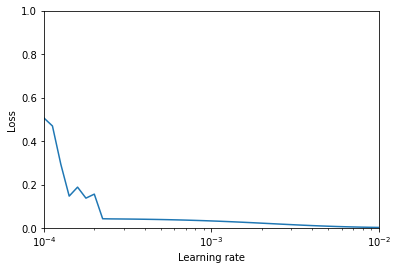

In [30]:
# Plot learning rate vs loss.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-2, 0., 1])
plt.xlabel('Learning rate')
plt.ylabel('Loss')

In [31]:
# Testing.

# Array preparation.
test_images = images_to_list(test_directory, image_dimension)
test_images = list_to_flatten(test_images, image_dimension)
   
labels = [[e]*len(os.listdir(directory + '/' + i)) for e, i in enumerate(os.listdir(directory))]
labels = list(itertools.chain.from_iterable(labels))
training_images = C2[:len(labels), :]

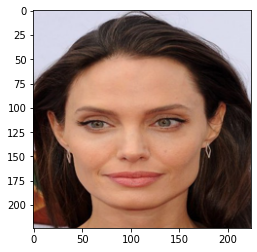

IMAGE 1 is Angelina with confidence of 100.0%


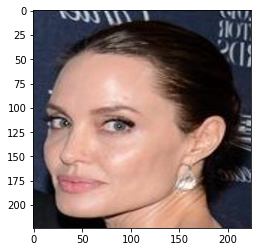

IMAGE 2 is Angelina with confidence of 100.0%


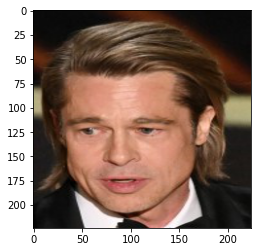

IMAGE 3 is Brad with confidence of 99.87%


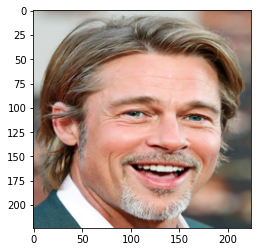

IMAGE 4 is Brad with confidence of 100.0%


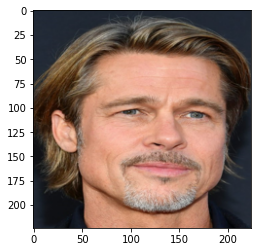

IMAGE 5 is Brad with confidence of 100.0%


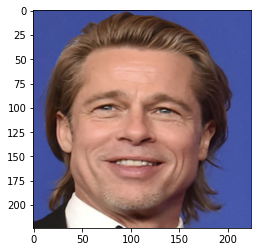

IMAGE 6 is Brad with confidence of 100.0%


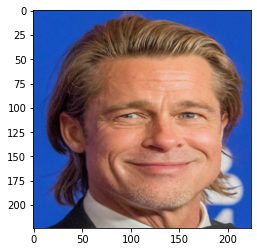

IMAGE 7 is Brad with confidence of 100.0%


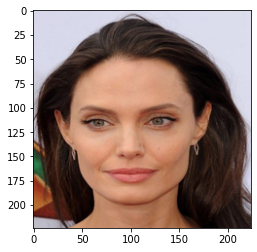

IMAGE 8 is Angelina with confidence of 100.0%


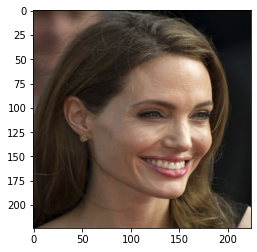

IMAGE 9 is Angelina with confidence of 100.0%


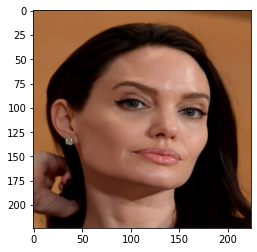

IMAGE 10 is Angelina with confidence of 100.0%


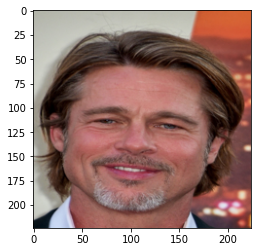

IMAGE 11 is Brad with confidence of 100.0%


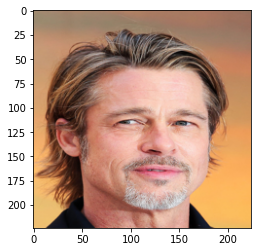

IMAGE 12 is Brad with confidence of 100.0%


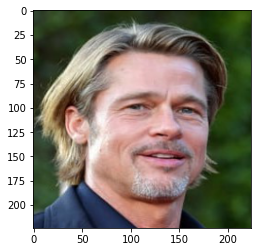

IMAGE 13 is Brad with confidence of 100.0%


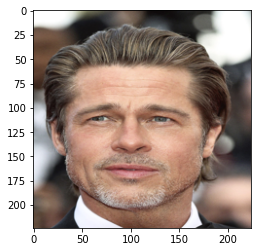

IMAGE 14 is Brad with confidence of 100.0%


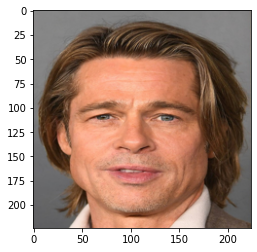

IMAGE 15 is Brad with confidence of 100.0%


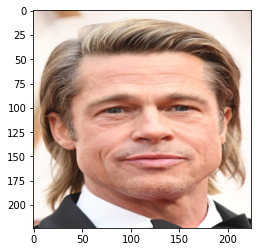

IMAGE 16 is Brad with confidence of 100.0%


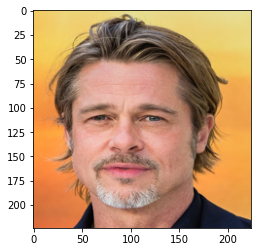

IMAGE 17 is Brad with confidence of 100.0%


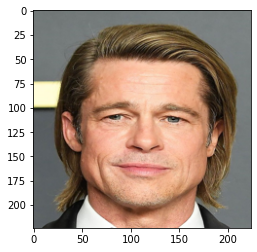

IMAGE 18 is Brad with confidence of 100.0%


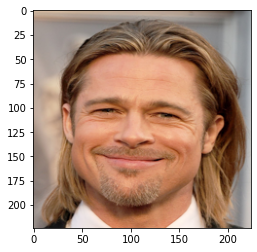

IMAGE 19 is Brad with confidence of 100.0%


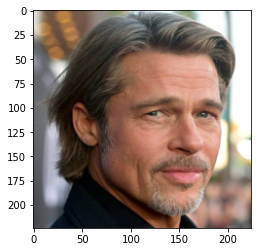

IMAGE 20 is Angelina with confidence of 100.0%


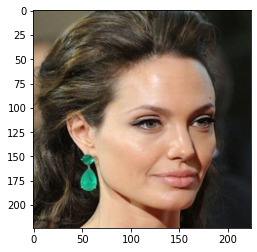

IMAGE 21 is Angelina with confidence of 100.0%


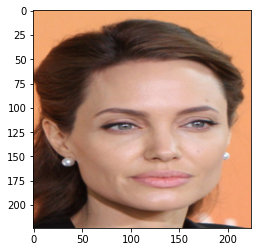

IMAGE 22 is Brad with confidence of 100.0%


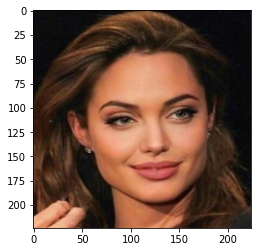

IMAGE 23 is Angelina with confidence of 100.0%


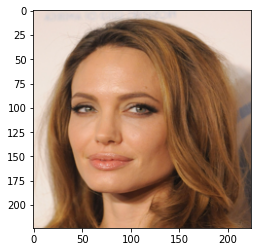

IMAGE 24 is Brad with confidence of 100.0%


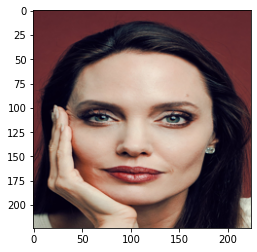

IMAGE 25 is Angelina with confidence of 100.0%


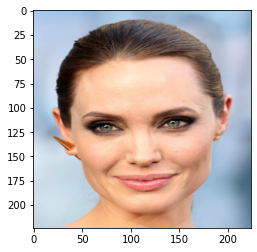

IMAGE 26 is Brad with confidence of 100.0%


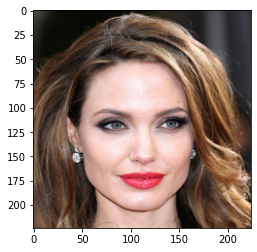

IMAGE 27 is Brad with confidence of 100.0%


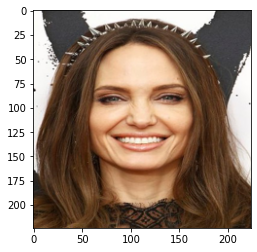

IMAGE 28 is Brad with confidence of 100.0%


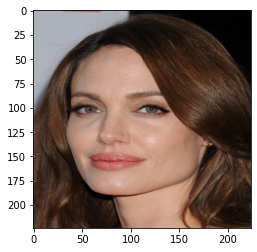

IMAGE 29 is Angelina with confidence of 100.0%


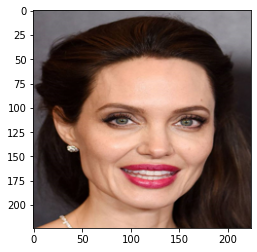

IMAGE 30 is Angelina with confidence of 100.0%


In [32]:
# Predict.
names = ['Angelina', 'Brad']
confidences = []
for e, tensor in enumerate(test_images, 1):
    
    # Show image.
    plt.imshow(np.rot90(tensor.reshape((image_dimension, image_dimension, 3)), k=-1))
    plt.show()
    
    # Predict scores.
    scores = [model.predict([tensor.reshape((1, -1)), sample.reshape((1, -1))])[0]  for sample in training_images]
    
    # Find the largest score, and its corresponding index.
    idx = np.argmax(scores)
    label = labels[idx]
    name = names[label] 
    print( 'IMAGE {} is {} with confidence of {}%'.format(e, name, round(100*scores[idx][0], 2)))
    confidences.append(scores[idx])